In [9]:
%load_ext autoreload
%autoreload 2
import xarray as xr
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from glob import glob

from utils.plotter import Plotter
from utils.data_handler import DataHandler

Plotter.change_folder("figs_simulation")
spin_up_days = 7
start_date = "2014-06-01"
end_date = "2014-08-31"

noos_folder = "/home/mverlaan/einf220/fromDavid/gtsm_openDA_david/stochObserver/noos_cmems_bk"
noos_file = lambda station: os.path.join(noos_folder, f"timeseries_{start_date}_{end_date}_{station}_averaged.noos")
locs_file = "/home/mverlaan/einf220/fromDavid/gtsm_openDA_david/stochModel/input_dflowfm/grid_locs.xyn"

av_file = "/home/mverlaan/einf220/fromDavid/saved_results/gtsm/simulation_mdt/gtsm_fine_0000_averaged_his.nc"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
xs_locs, ys_locs, stations = DataHandler.read_xyn(locs_file)
nc = xr.open_dataset(av_file)

stations_his = nc.station_name.values.tolist()
stations_his = np.array([s.decode("utf-8").strip() for s in stations_his])
nc["station_name"] = ("stations", stations_his)

rmses = []
for station in stations:
    # Get observations
    ts_obs, obs = DataHandler.read_noos(noos_file(station))

    # Get model results
    station_data = nc.where(nc.station_name == station).dropna("stations")
    sim = station_data.waterlevel.values.squeeze()
    ts = station_data.time.values.squeeze()

    rmses.append(np.std(obs - sim[spin_up_days:]))

    # Plot results
    # title_func = lambda s: f"Averaged water level at {s}"
    # observations = [ts_obs, obs]
    # Plotter.plot_series(
    #     [ts], [sim], station, title_func, obs_data=observations, legends=["No filter"]
    # )

<Figure size 640x480 with 0 Axes>

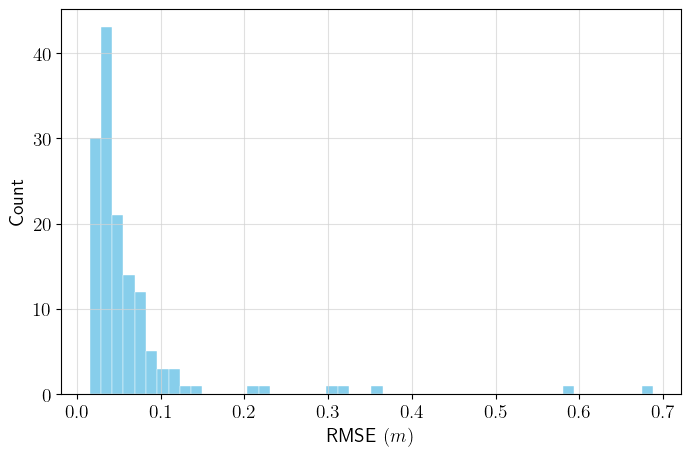

In [11]:
Plotter.hist(rmses, bins=50, path="hist_rmses.pdf", xlabel="RMSE $(m)$", ylabel="Count")
plt.show()

In [12]:
np.array(rmses).mean()

0.06400543835537846

(<Figure size 1400x500 with 2 Axes>,
 <GeoAxes: xlabel='Longitude', ylabel='Latitude'>)

<Figure size 640x480 with 0 Axes>

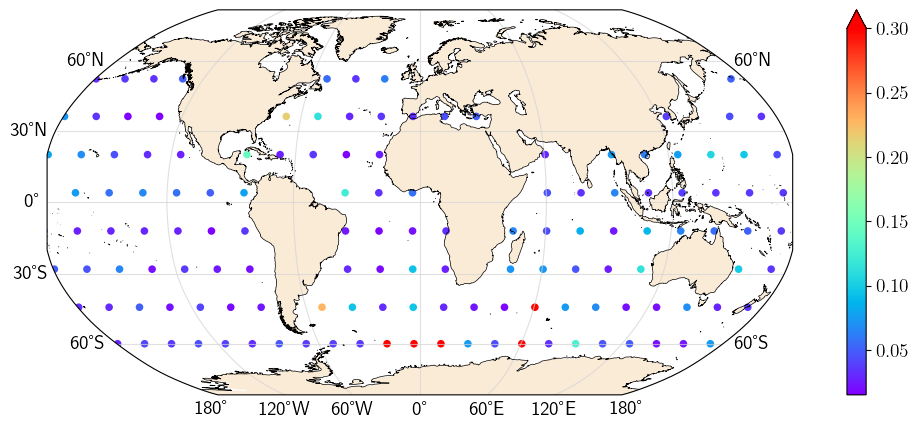

In [13]:
Plotter.plot_map(
    xs_locs,
    ys_locs,
    rmses,
    size=30,
    zorder_land=-1,
    cmap="rainbow",
    path="rmses.png",
    vmax=0.3,
    extent=(-180, 180, -90, 90),
)